In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 加载图像并将其转换为灰度图像
img = cv2.imread('./2-2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 高斯滤波降噪
gaussian_img = cv2.GaussianBlur(gray, (7, 7), 0)

# 边缘检测
edges = cv2.Canny(gaussian_img, 50, 150)

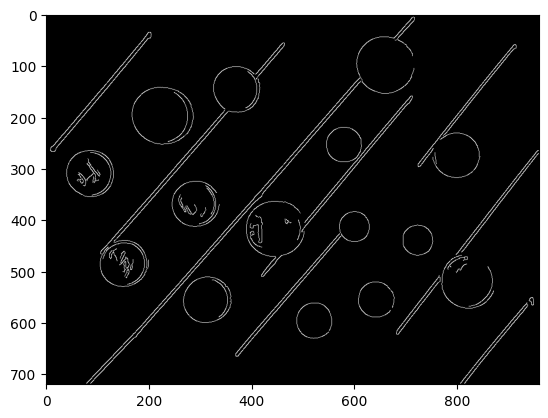

In [3]:
plt.imshow(edges, cmap='gray')

In [4]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
dilated_edges = cv2.dilate(edges, kernel, iterations=1)

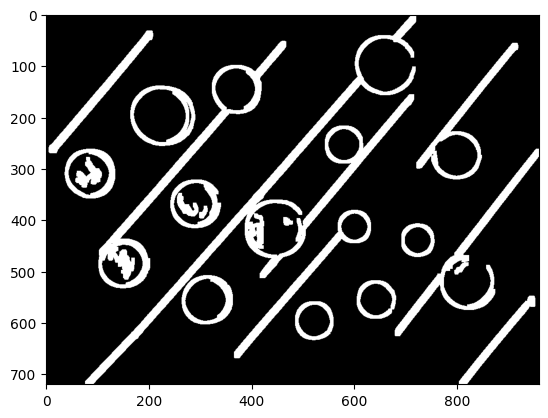

In [5]:
plt.imshow(dilated_edges, cmap='gray')

In [6]:
# 使用Hough线变换检测线条
lines = cv2.HoughLinesP(dilated_edges, 1, np.pi/180, 700, minLineLength=0, maxLineGap=200)

In [7]:
# 应用非最大抑制
def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        suppress = [last]

        for pos in range(last):
            j = idxs[pos]

            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)

            overlap = float(w * h) / area[j]

            if overlap > overlapThresh:
                suppress.append(pos)

        idxs = np.delete(idxs, suppress)

    return boxes[pick].astype("int")

In [8]:
# 应用非最大抑制来消除重叠的线段
new_lines = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    new_lines.append([x1, y1, x2, y2])

new_lines = np.array(new_lines)
new_lines = non_max_suppression(new_lines, 10)

In [9]:
# Merge the detected lines
merged_lines = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    if len(merged_lines) == 0:
        merged_lines.append(line[0])
    else:
        last_line = merged_lines[-1]
        if abs(x1 - last_line[2]) < 50 and abs(y1 - last_line[3]) < 50:
            merged_lines[-1][2:] = [x2, y2]
        else:
            merged_lines.append(line[0])

In [10]:
# Draw the merged lines
for line in merged_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

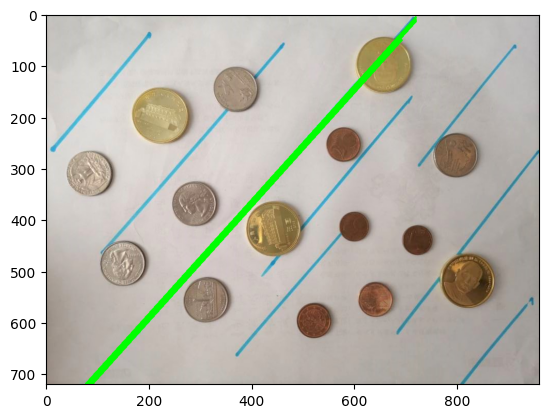

In [11]:
# 显示图像
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

检测到的线条数目： 9


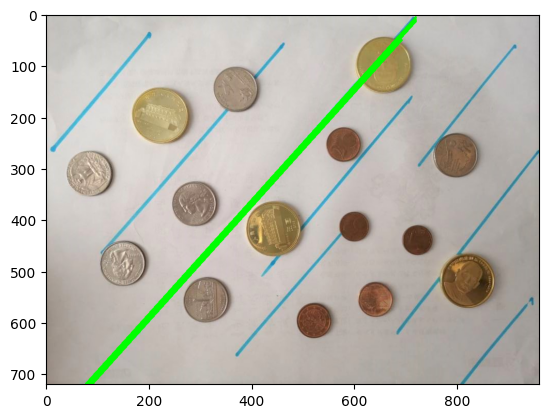

In [12]:
# 统计线条数目
line_count = len(new_lines)
print("检测到的线条数目：", line_count)

# 将检测到的线绘制到图像上
for line in new_lines:
    x1, y1, x2, y2 = line
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# 显示图像
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()